In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nltk
import re
import matplotlib.pyplot as plt
import dgl
import itertools

from allennlp.modules.elmo import Elmo, batch_to_ids
from eunjeon import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score

plt.rc('font', family='Malgun Gothic')

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
data_dir = '../analysis_files/files/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# 감성대화말뭉치(최종데이터)_Training.csv 파일을 pandas로 읽어옵니다.
df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation2.csv'), encoding='cp949')
df = df[['사람문장1', '시스템문장1', '사람문장2','시스템문장2','사람문장3','시스템문장3','감정_대분류', '상황키워드']]

In [8]:
# ELMo 모델 초기화
options_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json"
weight_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5"
elmo = Elmo(options_file, weight_file, num_output_representations=1)

# mecab 모델 다운로드
mecab = Mecab()

# elmo 모델 다운로드
elmo = elmo.to(device)

In [9]:
# 한국어 문장 형태소 분리 함수
def tokenize_korean_sentence(sentence):
    tokens = mecab.morphs(sentence)
    return tokens

In [10]:
def preprocessing(sentences) :
    sentences = re.sub(r'\([^)]*\)', '', sentences)
    sentences = sentences.replace('.', '')
    sentences = re.sub(r'[^가-힣\s]', '', sentences)
    sentences = re.sub(r'\b(?:cm|km|etc)\b', '', sentences)
    return sentences

In [11]:
def extract_sentence_features(sentence):
    # TF-IDF 벡터화 객체 생성
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")

    # 문장 길이
    sentence_length = len(sentence)

    # 품사 개수
    tokens = mecab.pos(sentence)
    pos_tags = [tag for _, tag in tokens]
    num_pos_tags = len(pos_tags)

    # 명사 추출
    nouns = mecab.nouns(sentence)

    # TF-IDF 벡터화 및 상위 3개 단어 추출
    top_words = ['', '', '']  # 단어가 없을 경우 빈 문자열로 초기화
    top_scores = [0.0, 0.0, 0.0]  # 단어가 없을 경우 TF-IDF 스코어를 0.0으로 초기화
    top_word_vectors = np.zeros((3,))  # 단어가 없을 경우 0 벡터로 초기화

    if nouns:
        tfidf_matrix = tfidf_vectorizer.fit_transform(nouns)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-3:][::-1]  # 상위 3개 단어의 인덱스 추출
        top_words = [feature_names[index] for index in top_indices]  # 상위 3개 단어 추출
        top_scores = [tfidf_scores[index] for index in top_indices]  # 상위 3개 단어의 TF-IDF 스코어 추출
        top_word_vectors = [tfidf_matrix.toarray()[0][index] for index in top_indices]  # 상위 3개 단어의 벡터값 추출

    return sentence_length, num_pos_tags, top_words, top_scores, top_word_vectors

In [12]:
data_train = []
data_test = []

# 레이블을 정수형으로 변환
label_mapping_emotion = {'기쁨': 0, '당황': 1, '분노': 2, '불안' : 3, '상처' : 4,'슬픔' : 5}  # 감정에 해당하는 레이블과 정수 매핑
label_mapping_situation = {'가족관계': 0, '건강': 1, '건강,죽음': 2, '대인관계' : 3, '대인관계(부부, 자녀)' : 4, '연애,결혼,출산' : 5, '재정' : 6, 
                        '재정,은퇴,노후준비' : 7, '직장, 업무 스트레스' : 8, '진로,취업,직장' : 9, '학교폭력/따돌림' : 10, '학업 및 진로' : 11}  # 상황에 해당하는 레이블과 정수 매핑

In [13]:
# 그래프 생성 및 노드 추가
graphs = []
for _, row in df.iterrows():
    G = nx.Graph()
    sentences = [row['사람문장1'], row['시스템문장1'], row['사람문장2'], row['시스템문장2'], row['사람문장3'], row['시스템문장3']]

    for i, sentence in enumerate(sentences):
        print(sentence)
        if pd.isna(sentence):  # NaN 값 처리
            sentence_embedding = torch.zeros(1024).to(device)  # 0 벡터로 처리
        else:
            sentence = preprocessing(sentence)
            # 문장을 형태소로 분리
            tokens = tokenize_korean_sentence(sentence)
            # 문장을 ELMo 임베딩으로 변환
            character_ids = batch_to_ids([tokens]).to(device)  # GPU로 이동
            embeddings_output = elmo(character_ids)  # GPU로 이동
            sentence_embedding = torch.mean(embeddings_output["elmo_representations"][0], dim=0).to('cpu')
            # 문장 특징 추출
            sentence_length, num_pos_tags, top_words, top_scores, top_word_vectors = extract_sentence_features(sentence)

            # 변환된 특징 데이터를 텐서로 변환
            sentence_embedding_tensor = torch.tensor(sentence_embedding)
            length_tensor = torch.tensor(sentence_length)
            pos_tags_tensor = torch.tensor(num_pos_tags)
            top_word_vectors_tensor = torch.tensor(top_word_vectors)

        G.add_node(i)

        # 노드 특성 추가
        G.nodes[i]['feature'] = sentence_embedding_tensor
        G.nodes[i]['length'] = length_tensor
        G.nodes[i]['pos_tags'] = pos_tags_tensor
        G.nodes[i]['top_word_vectors'] = top_word_vectors_tensor

        if i > 0:
            # 엣지 정보 생성
            edge_index = i-1  # 엣지 번호
            G.add_edge(i-1, i, edge_index=edge_index)  # 엣지 정보는 인덱스로 설정

            # 엣지 특성 추가
            G.edges[i-1, i]['edge_feature'] = edge_index  # 엣지 특성 설정

    # 감정 및 상황 레이블 할당
    y_emotion = label_mapping_emotion[row['감정_대분류']]
    y_situation = label_mapping_situation[row['상황키워드']]

    graphs.append((G, y_emotion, y_situation))

이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너무 미안해.


C:\Users\User\AppData\Local\Temp\ipykernel_2696\3207222834.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence_embedding_tensor = torch.tensor(sentence_embedding)


실수하시다니 정말 미안한 마음이 크겠어요.
내 능력이 부족한 거 같은데 그만 다녀야 될거같아.
능력을 올리려면 어떤 방법이 있을까요?
퇴근 후 여가에 회사 일을 더 열심히 해서 피해가 가지 않도록 해야겠어.
꼭 좋은 결과 있길 바라요.
회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.
큰 프로젝트를 혼자 하셔서 고민이 많겠네요.
나에게 너무 크게 느껴지는 중요한 프로젝트라 버거운 느낌이 들어.
프로젝트를 잘하시기 위해서 어떤 걸 할 수 있나요?
동료 직원에게 도움을 요청해서 같이 해결해야겠어.
동료 직원에게 도움을 요청하기로 하셨군요.
상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.
직장 상사가 무섭게 생기셔서 친해지는 게 어렵군요.
무섭게 생겼는데도 업무를 보려면 친해져야 할 것 같단말이야.
상사분과 친해질 수 있는 방법은 무엇이 있을까요?
먼저 다가가서 말을 걸어볼게.
직장 상사와 친해지시면 좋겠네요.
이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.
첫 직장이라서 정말 떨리시고 긴장되실 것 같아요.
첫 직장이어서 잘 적응을 할 수 있을지 모르겠어.
잘 적응 하시려면 무엇을 할 수 있을까요?
직장 동료와 상사들이랑 친하게 지내야겠어.
직장에 잘 적응하시길 바라요.
직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.
직장 사람들 관계에 대해서 고민이시군요.
내가 낯가림이 심해서 친해질 수 있을지 모르겠어.
직장 사람들과 친해지려면 무슨 방법이 있을까요?
서로 같은 취미를 공유하고 얘기를 나누다 보면 친해질 수 있을 거 같아.
직장 사람들과 좋은 관계를 가지시길 응원해요.
내가 평소에 말이 좀 험한 편인데 무서운 팀장님 앞에서 말실수할까 봐 걱정이야.
팀장님 앞에서 말실수를 할까 봐 두려우신가봐요.
팀장님 앞에서만 있으면 떨려.
말실수 안 하는 법은 무엇이 있나요?
평소에 말을 순하게 쓰려고 노력해서 앞에서 실수를 안 해야겠다.
팀장님 앞에서 실수를 안 하시길 바라요.
내 직급이 낮아서 그런지 회의 시간에 내 의

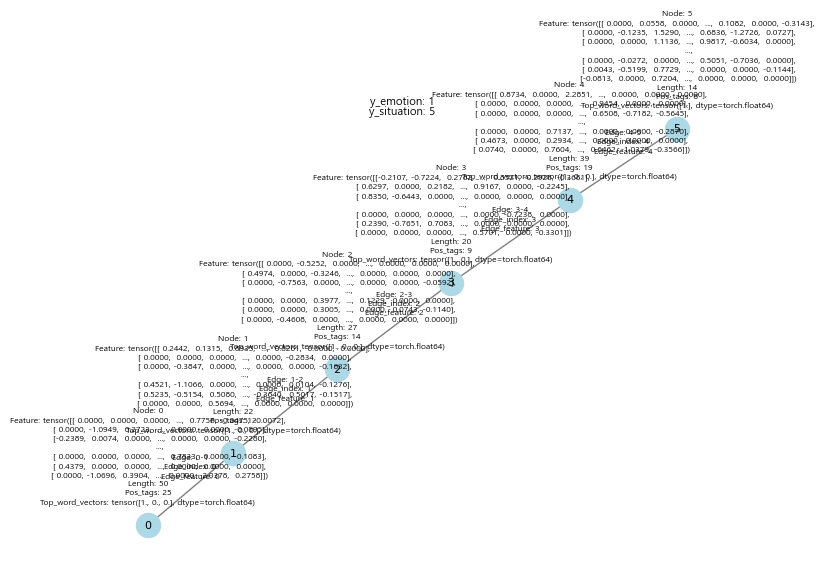

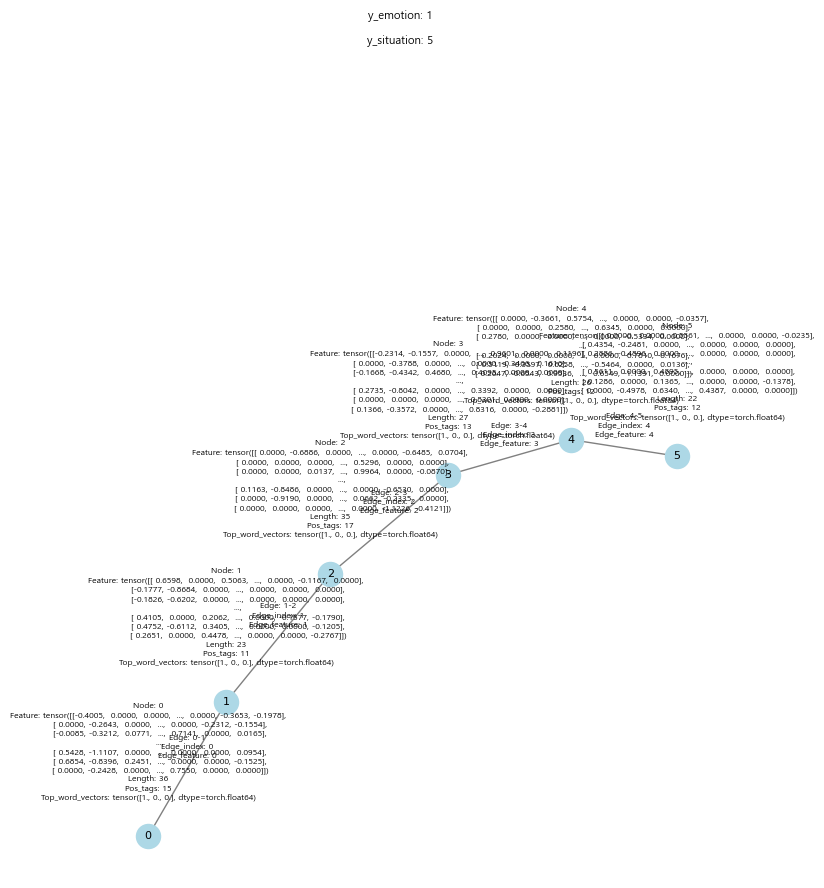

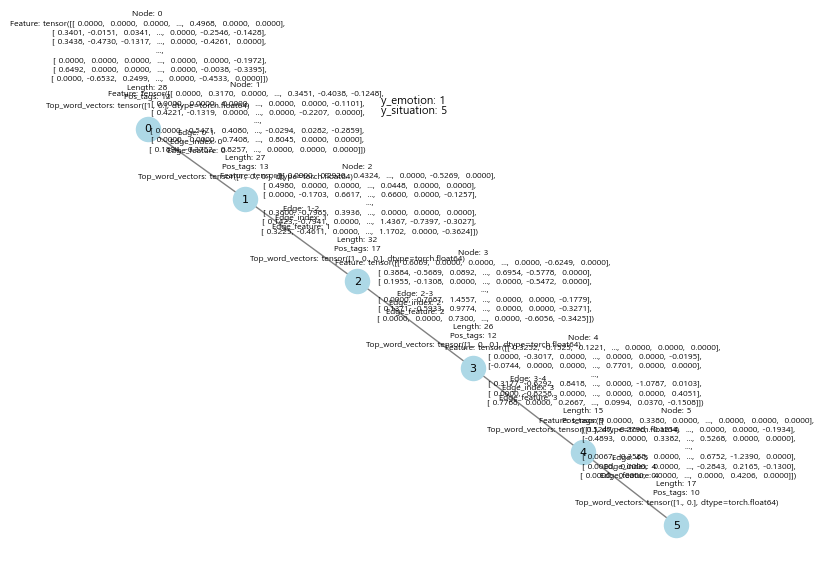

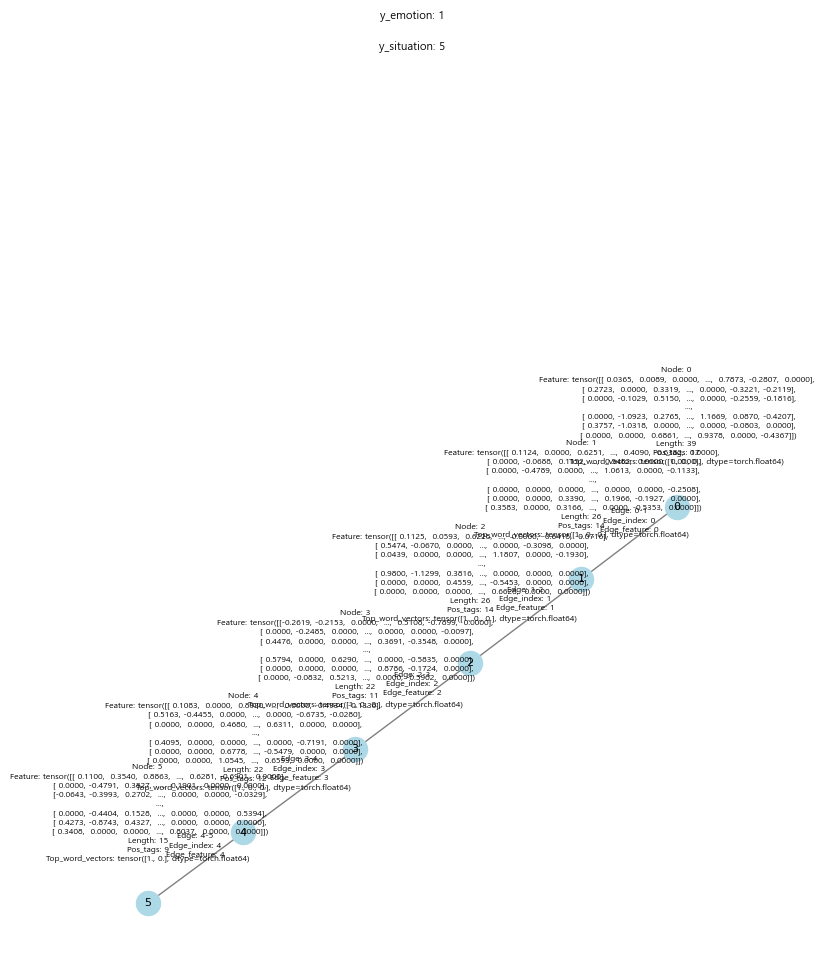

In [14]:
# 그래프 시각화
for i in range(4):  # 3개의 그래프만 표시
    graph, _, _ = graphs[i]  # graph, y_emotion, y_situation 중 graph만 사용
    pos = nx.spring_layout(graph)  # 그래프의 노드 위치 결정
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=8)  # 그래프 그리기
    node_attributes = graph.nodes(data=True)  # 노드의 속성 정보 가져오기
    edge_attributes = graph.edges(data=True)  # 엣지의 속성 정보 가져오기


    for node, attributes in node_attributes:
        x, y = pos[node]
        # 노드 속성 표시
        attribute_text = f"Node: {node}\n"
        for attr_name, attr_value in attributes.items():
            attribute_text += f"{attr_name.capitalize()}: {attr_value}\n"
        plt.text(x, y + 0.05, s=attribute_text, fontsize=6, ha='center', va='bottom')

    for edge in edge_attributes:
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        # 엣지 속성 표시
        attribute_text = f"Edge: {edge[0]}-{edge[1]}\n"
        for attr_name, attr_value in edge[2].items():
            attribute_text += f"{attr_name.capitalize()}: {attr_value}\n"
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, s=attribute_text, fontsize=6, ha='center', va='bottom')

    # y_emotion과 y_situation 레이블 표시
    y_emotion = label_mapping_emotion[row['감정_대분류']]
    y_situation = label_mapping_situation[row['상황키워드']]
    plt.text(0, 1.1, s=f"y_emotion: {y_emotion}", fontsize=8, ha='center', va='bottom')
    plt.text(0, 1.05, s=f"y_situation: {y_situation}", fontsize=8, ha='center', va='bottom')

    plt.show()

In [15]:
dgl_graphs = []
for (G, y_emotion, y_situation) in graphs:
    # Convert NetworkX graph to DGL graph
    dgl_G = dgl.DGLGraph(G)
    # 노드 및 엣지 속성을 graph.ndata 및 graph.edata에 저장
    num_nodes = len(G.nodes())
    dgl_G.ndata['feature'] = torch.zeros(num_nodes, 1024)
    dgl_G.ndata['length'] = torch.zeros(num_nodes)
    dgl_G.ndata['pos_tags'] = torch.zeros(num_nodes)
    dgl_G.ndata['top_word_vectors'] = torch.zeros(num_nodes, 3)  # top_word_vectors의 크기를 3으로 고정
    dgl_G.edata['edge_feature'] = torch.zeros(10)

    for i in G.nodes():
        feature = G.nodes[i]['feature']
        if feature.shape != (1024,):
            # feature의 크기가 (1024,)가 아닌 경우, 1024 차원의 평균을 취하여 크기를 (1024,)로 축소
            feature = torch.mean(feature, dim=0)
        dgl_G.ndata['feature'][i] = feature
        dgl_G.ndata['length'][i] = G.nodes[i]['length']
        dgl_G.ndata['pos_tags'][i] = G.nodes[i]['pos_tags']
        top_word_vectors = G.nodes[i]['top_word_vectors']
        if top_word_vectors.shape != (3,):
            # top_word_vectors의 크기가 (3,)가 아닌 경우, 3 차원으로 크기를 고정하고 0으로 채워진 텐서로 변환
            top_word_vectors = torch.tensor(top_word_vectors)
            expanded_top_word_vectors = torch.zeros(3)
            expanded_top_word_vectors[:top_word_vectors.size(0)] = top_word_vectors
            top_word_vectors = expanded_top_word_vectors
        dgl_G.ndata['top_word_vectors'][i] = top_word_vectors

    for i, j in G.edges():
        dgl_G.edata['edge_feature'][j-1] = G.edges[i, j]['edge_feature']

    dgl_G.ndata['y_emotion'] = torch.tensor([y_emotion] * num_nodes)
    dgl_G.ndata['y_situation'] = torch.tensor([y_situation] * num_nodes)

    dgl_graphs.append(dgl_G)

c:\Users\User\anaconda3\envs\torch\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
C:\Users\User\AppData\Local\Temp\ipykernel_2696\3657086150.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_word_vectors = torch.tensor(top_word_vectors)


In [16]:
for i in range(4):
    graph = dgl_graphs[i]
    print(f"Graph {i+1}:")
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Node features:")
    print(graph.ndata)
    print("Edge features:")
    print(graph.edata)
    print()

Graph 1:
Number of nodes: 6
Number of edges: 10
Node features:
{'feature': tensor([[ 0.1250, -0.4525,  0.2200,  ...,  0.2292, -0.2744, -0.0335],
        [ 0.1288, -0.3985,  0.2187,  ...,  0.2707, -0.0470, -0.1409],
        [ 0.1393, -0.3405,  0.0777,  ...,  0.0904, -0.1580, -0.0055],
        [ 0.1659, -0.3828,  0.1668,  ...,  0.4306, -0.0996, -0.1319],
        [ 0.0580, -0.0933,  0.3070,  ...,  0.4210, -0.2470, -0.0557],
        [-0.0096, -0.1157,  0.6731,  ...,  0.4201, -0.3769, -0.0775]]), 'length': tensor([50., 22., 27., 20., 39., 14.]), 'pos_tags': tensor([25., 12., 14.,  9., 19.,  8.]), 'top_word_vectors': tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), 'y_emotion': tensor([3, 3, 3, 3, 3, 3]), 'y_situation': tensor([9, 9, 9, 9, 9, 9])}
Edge features:
{'edge_feature': tensor([0., 1., 2., 3., 4., 0., 0., 0., 0., 0.])}

Graph 2:
Number of nodes: 6
Number of edges: 10
Node features:
{'feature': tenso

In [17]:
# 데이터 분할
train_graphs, test_graphs = train_test_split(dgl_graphs, test_size=0.2, random_state=42)

In [20]:
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = dgl.nn.GraphConv(input_dim, hidden_dim)
        self.conv2 = dgl.nn.GraphConv(hidden_dim, hidden_dim)
        self.conv3 = dgl.nn.GraphConv(hidden_dim, hidden_dim)
        self.fc_emotion = nn.Linear(hidden_dim, output_dim['emotion'])
        self.fc_situation = nn.Linear(hidden_dim, output_dim['situation'])

    def forward(self, g):
        x = g.ndata['feature']
        # length = g.ndata['length']
        # pos_tags = g.ndata['pos_tags']
        # top_word_vectors = g.ndata['top_word_vectors']
        # edge_index = g.edata['edge_feature']

        x = self.conv1(g, x)
        x = F.relu(x)
        x = self.conv2(g, x)
        x = F.relu(x)
        x = self.conv3(g, x)
        x = F.relu(x)

        # x = dgl.mean_nodes(g, x)  # 그래프의 특성을 하나의 벡터로 요약

        # 속성들을 모델에 입력으로 추가
        # x = torch.cat([x, length, pos_tags, top_word_vectors], dim=1)

        emotion_out = self.fc_emotion(x)
        situation_out = self.fc_situation(x)

        return emotion_out, situation_out

In [21]:
# 학습 모델 초기화 및 손실 함수, 옵티마이저 설정
input_dim = 1024
hidden_dim = 128
output_dim = {'emotion': len(label_mapping_emotion), 'situation': len(label_mapping_situation)}
model = GCNModel(input_dim, hidden_dim, output_dim)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# 데이터 로더 생성
batch_size = 32
train_loader = GraphDataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = GraphDataLoader(test_graphs, batch_size=batch_size, shuffle=True)


In [23]:
# 평가 함수 정의
def evaluate(model, dataloader):
    model.eval()
    y_true_emotion = []
    y_pred_emotion = []
    y_true_situation = []
    y_pred_situation = []

    with torch.no_grad():
        for batch in dataloader:
            g = batch
            labels_emotion = g.ndata['y_emotion']
            labels_situation = g.ndata['y_situation']

            outputs_emotion, outputs_situation = model(g)
            _, predicted_emotion = torch.max(outputs_emotion, 1)
            _, predicted_situation = torch.max(outputs_situation, 1)
            y_true_emotion.extend(labels_emotion.tolist())
            y_pred_emotion.extend(predicted_emotion.tolist())
            y_true_situation.extend(labels_situation.tolist())
            y_pred_situation.extend(predicted_situation.tolist())

    accuracy_emotion = accuracy_score(y_true_emotion, y_pred_emotion)
    recall_emotion = recall_score(y_true_emotion, y_pred_emotion, average='macro')
    f1_emotion = f1_score(y_true_emotion, y_pred_emotion, average='macro')
    accuracy_situation = accuracy_score(y_true_situation, y_pred_situation)
    recall_situation = recall_score(y_true_situation, y_pred_situation, average='macro')
    f1_situation = f1_score(y_true_situation, y_pred_situation, average='macro')

    return accuracy_emotion, recall_emotion, f1_emotion, accuracy_situation, recall_situation, f1_situation



In [24]:
num_epochs = 1000
train_acc_emotion_list = []
train_acc_situation_list = []
test_acc_emotion_list = []
test_acc_situation_list = []

for epoch in range(num_epochs):
    model.train()

    for batch in train_loader:
        g = batch
        labels_emotion = g.ndata['y_emotion']
        labels_situation = g.ndata['y_situation']
        optimizer.zero_grad()
        outputs_emotion, outputs_situation = model(g)
        loss_emotion = loss_function(outputs_emotion, labels_emotion)
        loss_situation = loss_function(outputs_situation, labels_situation)
        loss = loss_emotion + loss_situation
        loss.backward()
        optimizer.step()

    # 학습 데이터에 대한 평가
    train_accuracy_emotion, train_recall_emotion, train_f1_emotion, train_accuracy_situation, train_recall_situation, train_f1_situation = evaluate(model, train_loader)
    # 테스트 데이터에 대한 평가
    test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_loader)

    # Append accuracy values to the lists
    train_acc_emotion_list.append(train_accuracy_emotion)
    train_acc_situation_list.append(train_accuracy_situation)
    test_acc_emotion_list.append(test_accuracy_emotion)
    test_acc_situation_list.append(test_accuracy_situation)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Emotion Accuracy: {train_accuracy_emotion:.4f} Recall: {train_recall_emotion:.4f} F1-score: {train_f1_emotion:.4f}")
    print(f"Train Situation Accuracy: {train_accuracy_situation:.4f} Recall: {train_recall_situation:.4f} F1-score: {train_f1_situation:.4f}")
    print(f"Test Emotion Accuracy: {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
    print(f"Test Situation Accuracy: {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
    print()


Epoch 1/1000:
Train Emotion Accuracy: 0.1920 Recall: 0.1667 F1-score: 0.0540
Train Situation Accuracy: 0.2001 Recall: 0.0833 F1-score: 0.0278
Test Emotion Accuracy: 0.1783 Recall: 0.1667 F1-score: 0.0505
Test Situation Accuracy: 0.2257 Recall: 0.0833 F1-score: 0.0307

Epoch 2/1000:
Train Emotion Accuracy: 0.2188 Recall: 0.1938 F1-score: 0.1090
Train Situation Accuracy: 0.2001 Recall: 0.0833 F1-score: 0.0278
Test Emotion Accuracy: 0.1986 Recall: 0.1879 F1-score: 0.1008
Test Situation Accuracy: 0.2257 Recall: 0.0833 F1-score: 0.0307

Epoch 3/1000:
Train Emotion Accuracy: 0.2189 Recall: 0.1948 F1-score: 0.1074
Train Situation Accuracy: 0.2001 Recall: 0.0833 F1-score: 0.0278
Test Emotion Accuracy: 0.1963 Recall: 0.1862 F1-score: 0.0957
Test Situation Accuracy: 0.2257 Recall: 0.0833 F1-score: 0.0307

Epoch 4/1000:
Train Emotion Accuracy: 0.2280 Recall: 0.2035 F1-score: 0.1367
Train Situation Accuracy: 0.2028 Recall: 0.0903 F1-score: 0.0434
Test Emotion Accuracy: 0.2114 Recall: 0.2040 F1-sco

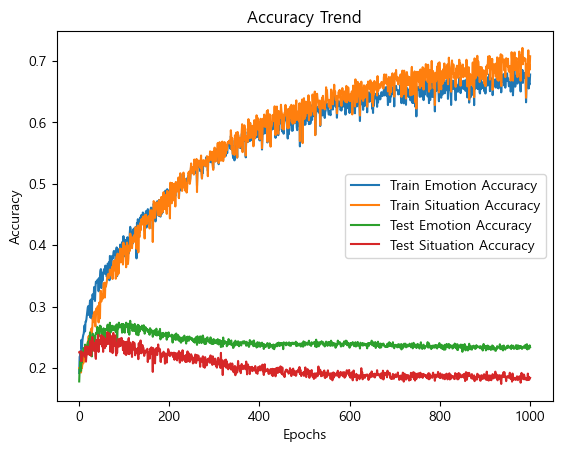

In [25]:
# Plotting the accuracy trend
epochs = range(1, num_epochs+1)

plt.plot(epochs, train_acc_emotion_list, label='Train Emotion Accuracy')
plt.plot(epochs, train_acc_situation_list, label='Train Situation Accuracy')
plt.plot(epochs, test_acc_emotion_list, label='Test Emotion Accuracy')
plt.plot(epochs, test_acc_situation_list, label='Test Situation Accuracy')

plt.title('Accuracy Trend')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

num_epochs = 10
k = 5  # K-Fold Cross Validation의 K 값 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터셋을 K-Fold로 분할
kf = KFold(n_splits=k, shuffle=True)

# K-Fold Cross Validation 반복
for fold, (train_idx, test_idx) in enumerate(kf.split(graphs)):
    print(f"Fold {fold+1}/{k}")

    # 데이터셋 분할
    train_graphs = [graphs[i] for i in train_idx]
    test_graphs = [graphs[i] for i in test_idx]

    # 모델 초기화
    model = GCNModel(input_dim, hidden_dim, output_dim).to(device)
    loss_function = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader = GraphDataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = GraphDataLoader(test_graphs, batch_size=batch_size, shuffle=True)

    train_acc_emotion_list = []
    train_acc_situation_list = []
    test_acc_emotion_list = []
    test_acc_situation_list = []

    # 학습 및 평가 반복
    for epoch in range(num_epochs):
        model.train()

        for batch in train_loader:
            g = batch
            labels_emotion = g.ndata['y_emotion']
            labels_situation = g.ndata['y_situation']
            optimizer.zero_grad()
            outputs_emotion, outputs_situation = model(g)
            loss_emotion = loss_function(outputs_emotion, labels_emotion)
            loss_situation = loss_function(outputs_situation, labels_situation)
            loss = loss_emotion + loss_situation
            loss.backward()
            optimizer.step()

        # 학습 데이터에 대한 평가
        train_accuracy_emotion, train_recall_emotion, train_f1_emotion, train_accuracy_situation, train_recall_situation, train_f1_situation = evaluate(model, train_loader)
        # 테스트 데이터에 대한 평가
        test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_loader)

        # Append accuracy values to the lists
        train_acc_emotion_list.append(train_accuracy_emotion)
        train_acc_situation_list.append(train_accuracy_situation)
        test_acc_emotion_list.append(test_accuracy_emotion)
        test_acc_situation_list.append(test_accuracy_situation)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Emotion Accuracy: {train_accuracy_emotion:.4f} Recall: {train_recall_emotion:.4f} F1-score: {train_f1_emotion:.4f}")
        print(f"Train Situation Accuracy: {train_accuracy_situation:.4f} Recall: {train_recall_situation:.4f} F1-score: {train_f1_situation:.4f}")
        print(f"Test Emotion Accuracy: {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
        print(f"Test Situation Accuracy: {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
        print()

    # 모델 저장
    torch.save(model.state_dict(), f'model_fold{fold+1}.pt')

    # 저장된 모델을 불러와서 다시 교차 검증
    model = GCNModel(input_dim, hidden_dim, output_dim).to(device)
    model.load_state_dict(torch.load(f'model_fold{fold+1}.pt'))
    model.eval()

    # 평가 함수를 사용하여 교차 검증 진행
    test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_loader)
    print(f"Test Emotion Accuracy (Loaded Model): {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
    print(f"Test Situation Accuracy (Loaded Model): {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
    print()

In [ ]:
# 하이퍼파라미터 조합 정의
input_dim_list = [1024, 512]
hidden_dim_list = [128, 256]
lr_list = [0.0001, 0.001, 0.01]
param_combinations = list(itertools.product(input_dim_list, hidden_dim_list, lr_list))

best_accuracy_emotion = 0.0
best_accuracy_situation = 0.0
best_params = {}

# Grid Search 실행
for params in param_combinations:
    input_dim, hidden_dim, lr = params

    # 모델 초기화
    model = GCNModel(input_dim, hidden_dim, output_dim)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 학습
    for epoch in range(num_epochs):
        model.train()

        for batch in train_loader:
            g = batch
            labels_emotion = g.ndata['y_emotion']
            labels_situation = g.ndata['y_situation']
            optimizer.zero_grad()
            outputs_emotion, outputs_situation = model(g)
            loss_emotion = loss_function(outputs_emotion, labels_emotion)
            loss_situation = loss_function(outputs_situation, labels_situation)
            loss = loss_emotion + loss_situation
            loss.backward()
            optimizer.step()

    # 평가
    train_accuracy_emotion, _, _, train_accuracy_situation, _, _ = evaluate(model, train_loader)
    test_accuracy_emotion, _, _, test_accuracy_situation, _, _ = evaluate(model, test_loader)

    # 최고 정확도를 갱신하면 최적의 파라미터 및 모델 저장
    if test_accuracy_emotion > best_accuracy_emotion and test_accuracy_situation > best_accuracy_situation:
        best_accuracy_emotion = test_accuracy_emotion
        best_accuracy_situation = test_accuracy_situation
        best_params = {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'lr': lr}
        torch.save(model.state_dict(), 'best_model.pt')

# 최적의 파라미터 출력
print("Best Parameters:")
print(best_params)
print(f"Best Emotion Accuracy: {best_accuracy_emotion:.4f}")
print(f"Best Situation Accuracy: {best_accuracy_situation:.4f}")